In [1]:
!pip install gradio

     |████████████████████████████████| 2.0 MB 11.4 MB/s 
     |████████████████████████████████| 1.9 MB 48.9 MB/s 
     |████████████████████████████████| 206 kB 57.1 MB/s 
     |████████████████████████████████| 961 kB 49.4 MB/s 
     |████████████████████████████████| 3.5 MB 46.9 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=64eba722bd23ff0172399f736ec172452b808a56bdf26e2511481166ca945508
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=6c5a0cb4be09786835b24ac4783c5bf535a1006c35cfab6ec940aecd64591a8e
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [2]:
import tensorflow as tf
import gradio as gr
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import tensorflow_datasets as tfds
import pickle
from PIL import Image, ImageOps

In [4]:
import zipfile
import os
import requests
import itertools

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image

In [6]:
import numpy as np
import datetime

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def load_class():
  with open ('/content/drive/MyDrive/Model/outfile.txt', 'rb') as fp:
      itemlist = pickle.load(fp)
      print(itemlist)
  return itemlist

<HR>

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
                 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
 
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
def unzip_data(filename):
 
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
def calculate_results(y_true, y_pred):
 
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:

def create_tensorboard_callback(dir_name, experiment_name):
 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
# Plot the validation and training data separately


def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:

def compare_historys(original_history, new_history, initial_epochs=5):

    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)

In [ ]:

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.


def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=("train,validation") # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3MN8S3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3MN8S3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


ValueError: ignored

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved


In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
with open('outfile.txt', 'wb') as fp:
    pickle.dump(class_names, fp)

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label


  Image shape: (341, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 78
  Class name (str form): poutine
        


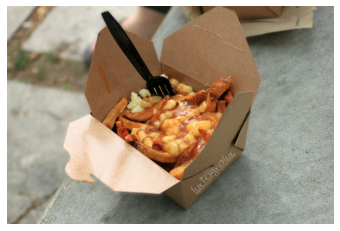

In [ ]:
i= train_data.take(1)
for image, label in i:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)
  plt.imshow(image/255)
  plt.axis(False)
  plt.savefig('plot.jpg')

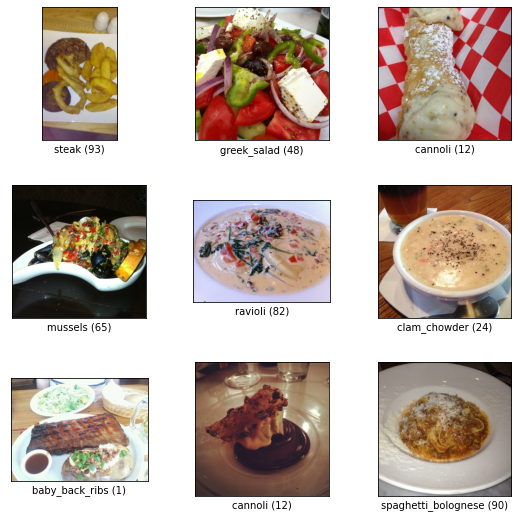

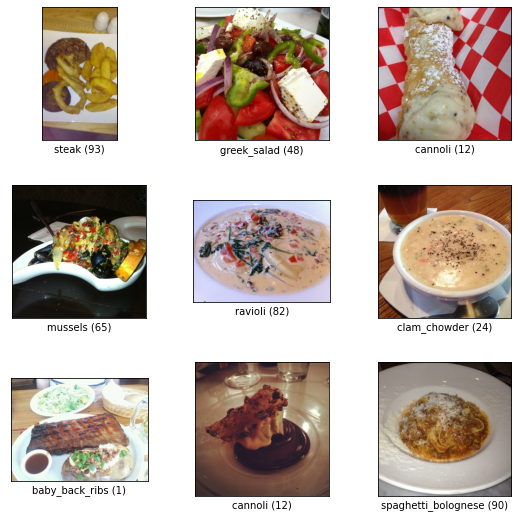

In [ ]:
tfds.show_examples(train_data, ds_info)

In [ ]:

  # Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  # Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  # Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# Create base model
with strategy.scope():
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

    # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
    # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  #x = preprocessing.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class 
    # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  model = tf.keras.Model(inputs, outputs)

    # Compile the model
  model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
path = 'saved_model/'

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                        epochs=11,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.10 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", 
                                                                                                "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

In [ ]:
model.save("my_model.h5")
model.save(path, save_format='tf')

In [ ]:
model.evaluate(test_data)

In [ ]:
with strategy.scope():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB4(include_top=False)
    base_model.trainable = False # freeze base model layers

      # Create Functional model 
    inputs = layers.Input(shape=input_shape, name="input_layer")
      # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
    #x = preprocessing.Rescaling(1./255)(x)
    x = base_model(inputs, training=False) # set base_model to inference mode only
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x) # want one output neuron per class 
      # Separate activation of output layer so we can output float32 activations
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
    model2 = tf.keras.Model(inputs, outputs)

      # Compile the model
    model2.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
path = 'saved_model2/'

In [ ]:
history_101_food_classes_feature_extract2 = model2.fit(train_data, 
                                                        epochs=12,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.10 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", 
                                                                                                "efficientnetb4_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

In [ ]:
model2.evaluate(test_data)

In [ ]:
model2.save("my_model2.h5")
model2.save(path, save_format='tf')

In [ ]:
!tensorboard dev upload --logdir ./training_logs 
  --name "EfficientNetB0 on Food101 Data" 
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data" 
  --one_shot

<HR>

In [9]:
!mkdir download_model
!unzip '/content/drive/MyDrive/Model/saved_model.zip' -d download_model
!mkdir download_model2
!unzip '/content/drive/MyDrive/Model/saved_model2.zip' -d download_model2

Archive:  /content/drive/MyDrive/Model/saved_model.zip
   creating: download_model/saved_model/
  inflating: download_model/saved_model/saved_model.pb  
   creating: download_model/saved_model/variables/
  inflating: download_model/saved_model/variables/variables.data-00000-of-00001  
  inflating: download_model/saved_model/variables/variables.index  
Archive:  /content/drive/MyDrive/Model/saved_model2.zip
   creating: download_model2/saved_model2/
  inflating: download_model2/saved_model2/saved_model.pb  
   creating: download_model2/saved_model2/variables/
  inflating: download_model2/saved_model2/variables/variables.data-00000-of-00001  
  inflating: download_model2/saved_model2/variables/variables.index  


In [10]:
b0 = tf.keras.models.load_model("/content/download_model/saved_model")
b4 = tf.keras.models.load_model("/content/download_model2/saved_model2")

In [11]:
class_names=load_class()
def classify_b0(img,img_shape=224):
   #img = tf.image.decode_jpeg(img)
   # Resize the image
   #img=img/255
   img = tf.image.resize(img,size=[img_shape,img_shape])
   newimg = np.asarray(img)
   pixels = newimg.astype('float32')
   pixels = np.expand_dims(pixels, axis=0)
   t=tf.convert_to_tensor(pixels,dtype=tf.float32)
   prediction = b0.predict(t).flatten()
   return {labels[i]: float(prediction[i]) for i in range(101)}
def classify_b4(img,img_shape=224):
   #img = tf.image.decode_jpeg(img)
   # Resize the image
   #img=img/255
   img = tf.image.resize(img,size=[img_shape,img_shape])
   newimg = np.asarray(img)
   pixels = newimg.astype('float32')
   pixels = np.expand_dims(pixels, axis=0)
   t=tf.convert_to_tensor(pixels,dtype=tf.float32)
   prediction = b4.predict(t).flatten()
   return {labels[i]: float(prediction[i]) for i in range(101)}
#images


labels=class_names
image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=3)
gr.Interface([classify_b0,classify_b4],image,label,title="Efficient B0 vs Efficent B4").launch(debug=True);

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

KeyboardInterrupt: ignored